In [1]:
# load ndjson file
import ndjson
import pandas as pd
from rdflib import Graph, Literal, Namespace
from rdflib.namespace import OWL, SKOS
import unicodedata
import matplotlib.pyplot as plt
import datetime

In [2]:
# load current YSA
ysa = Graph()
ysa.parse('http://finto.fi/rest/v1/ysa/data?format=text/turtle')
print('Number of triples in YSA: ', len(ysa))

# load current Allärs
allars = Graph()
allars.parse('http://finto.fi/rest/v1/allars/data?format=text/turtle')
print('Number of triples in Allärs: ', len(allars))


Failed to convert Literal lexical form to value. Datatype=http://www.w3.org/2001/XMLSchema#date, Converter=<function parse_date at 0x7fa242d28310>
Traceback (most recent call last):
  File "/home/local/jmminkin/git/FintoAI-data-YSO/repository-metrics-analysis/venv-old/lib/python3.8/site-packages/rdflib/term.py", line 2084, in _castLexicalToPython
    return conv_func(lexical)  # type: ignore[arg-type]
  File "/home/local/jmminkin/git/FintoAI-data-YSO/repository-metrics-analysis/venv-old/lib/python3.8/site-packages/isodate/isodates.py", line 201, in parse_date
    return date(sign * int(groups['year']),
ValueError: month must be in 1..12


Number of triples in YSA:  433048
Number of triples in Allärs:  412097


FileNotFoundError: [Errno 2] No such file or directory: '/home/local/jmminkin/git/git/Annif-corpora/vocab/yso-skos.ttl'

In [5]:
# load YSO and YSO Places
yso = Graph()
yso.parse("../Annif-corpora/vocab/yso-skos.ttl", format='turtle')
print('Number of triples in YSO+YSO Places: ', len(yso))

Number of triples in YSO+YSO Places:  830887


# Helper functions

In [77]:
YSO = Namespace('http://www.yso.fi/onto/yso/')
COMPLAIN = False  # whether to complain about unknown labels


def is_deprecated(ysouri):
    return (ysouri, OWL.deprecated, True) in yso


def label_to_yso_uris(label, voc, lang, complain=COMPLAIN):
    # based on https://github.com/NatLibFi/Annif-corpora/blob/6521d0357f3d93019f6d2838b960e80d9131735c/tools/finna-metadata-collect-scripts/create-corpus.py#L54
    
    # Remove trailing "." present in labels of some records
    try:
        value = Literal(unicodedata.normalize('NFC', label.rstrip('.')), lang)
    except Exception as e:
        print("Error normalizing label '{}'".format(label))
        return []

    for prop in (SKOS.prefLabel, SKOS.altLabel):
        vocuri = voc.value(None, prop, value, any=True)
        if vocuri is not None:
            if vocuri.startswith(YSO):
                return [vocuri]
            for matchprop in (SKOS.exactMatch, SKOS.closeMatch):
                matches = [match for match in voc.objects(vocuri, matchprop)
                           if match.startswith(YSO)]
                if matches:
                    return matches

    # hackish fallbacks for cases like "kulttuuri", where YSO Cicero is out of
    # date: look up via ysa/allars
    if lang == 'fi' and voc == yso:
        matches = label_to_yso_uris(label, ysa, lang)
        if matches:
            print("missing fi label '{}' found via ysa".format(label))
            return matches

    if lang == 'sv' and voc == yso:
        matches = label_to_yso_uris(label, allars, lang)
        if matches:
            print("missing sv label '{}' found via allars".format(label))
            return matches

    if complain:
        print("Unknown label '{}'".format(label))
    return []

def add_subjects_uris(df, lang, source_col):
    df["subjects_uris"] = df[source_col].apply(lambda x: [label_to_yso_uris(label, yso, lang, COMPLAIN) for label in x])
    df["subjects_uris"] = df["subjects_uris"].apply(lambda x: [str(item) for sublist in x for item in sublist])
    return df


def calc_scores(df):
    # calculate precision, recall, f1
    df["precision"] = df.apply(lambda x: len(set(x.subjects_uris) & set(x.suggestions)) / len(x.suggestions) if len(x.suggestions) > 0 else pd.np.nan, axis=1)
    df["recall"] = df.apply(lambda x: len(set(x.subjects_uris) & set(x.suggestions)) / len(x.subjects_uris) if len(x.subjects_uris) > 0 else pd.np.nan, axis=1)
    df["f1 score"] = df.apply(lambda x: 2 * x.precision * x.recall / (x.precision + x.recall) if (x.precision + x.recall) != 0 else 0, axis=1)
    df['f1 score'] = pd.to_numeric(df['f1 score'])


def plot_scores(df, date_col, groupby='M'):
    calc_scores(df)
    # plot precision, recall, f1 as a function of date_col grouped by groupby
    df = df.set_index(date_col)
    df.resample(groupby).mean().plot(marker='o')
    plt.grid()
    # plt.title(f"Precision, recall, f1 scores by {date_col} grouped by {groupby}")

    # mark annif_updates in the plot
    for upd in annif_updates:
        plt.axvline(upd, color='red', linestyle='--')


def get_number_of_rows(df):
    print("rows: ", len(df))
    print("rows with subjects_yso: ", len(df[df.subjects_yso.apply(lambda x: len(x) > 0)]))
    print("rows with subjects_all: ", len(df[df.subjects_all.apply(lambda x: len(x) > 0)]))
    print("rows with suggestions: ", len(df[df.suggestions.apply(lambda x: len(x) > 0)]))
    print("rows with subjects_uris: ", len(df[df.subjects_uris.apply(lambda x: len(x) > 0)]))
    print("rows with both suggestions & subject_uris: ", len(retain_relevant(df)))
    # print("rows with both suggestions & subject_uris: ", len(df[df.suggestions.apply(lambda x: len(x) > 0) & df.subjects_uris.apply(lambda x: len(x) > 0)]))
    # print("rows without subjects_uris: ", len(df[df.subjects_uris.apply(lambda x: len(x) == 0)]))
    # print("rows without suggestions: ", len(df[df.suggestions.apply(lambda x: len(x)
    # == 0)]))


def retain_relevant(df):
    df = df.copy()
    return df[df.suggestions.apply(lambda x: len([e for e in x if e != '']) > 0) & df.subjects_uris.apply(lambda x: len([e for e in x if e != '']) > 0)]


# Dates when Annif models were updated in Finto AI
annif_updates = [
    # "2020-03-26",
    "2020-12-09",
    "2021-04-27",
    "2021-11-11",
    "2022-06-21",
    "2022-11-22",
]
# convert to datetime with utc timezone
annif_updates = [datetime.datetime.strptime(x, "%Y-%m-%d").replace(tzinfo=datetime.timezone.utc) for x in annif_updates]

def get_annif_update(date):
    return max([upd for upd in annif_updates if upd<date], default=None)


# Osuva
Annif integration to use in Osuva in 11.3.2020

In [78]:
with open("osuva.ndjson") as f:
    data = ndjson.load(f)
df = pd.DataFrame(data)

df.date_issued = pd.to_datetime(df.date_issued, errors='coerce', utc=True)
df.date_accessioned = pd.to_datetime(df.date_accessioned, errors='coerce', utc=True)
df['annif_update'] = df.date_accessioned.map(get_annif_update)

print(len(df))
print(len(df[df.language == 'fin']))
print(len(df[df.language == 'eng']))
print(len(df[df.language == 'swe']))

12699
6103
4783
303


In [103]:
df_fi = df[df.language == 'fin']
df_fi = add_subjects_uris(df_fi, 'fi', source_col='subjects_all')
get_number_of_rows(df_fi)
# Retain only rows having both suggestions and subjects_uris
df_fi = retain_relevant(df_fi)
title_str = "Osuva Finnish"

missing fi label 'itsesäätely' found via ysa
missing fi label 'arvot' found via ysa
missing fi label 'FEM' found via ysa
missing fi label 'vankeus' found via ysa
missing fi label 'lähteet' found via ysa
missing fi label 'asetukset' found via ysa
Error normalizing label 'None'
missing fi label 'arvot' found via ysa
missing fi label 'rajapinnat (tietokoneohjelmat)' found via ysa
missing fi label 'rajapinnat (tietokoneohjelmat)' found via ysa
missing fi label 'arvot' found via ysa
missing fi label 'klubitalot' found via ysa
missing fi label 'arvot' found via ysa
missing fi label 'maalit' found via ysa
missing fi label 'rajapinnat (tietokoneohjelmat)' found via ysa
missing fi label 'ekosysteemit' found via ysa
missing fi label 'arvot' found via ysa
missing fi label 'ohjelmistot' found via ysa
missing fi label 'kuraattorit' found via ysa
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
missing fi label 'sijoitukset' found via ysa
missing fi label 

/tmp/ipykernel_818734/2689655410.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["subjects_uris"] = df[source_col].apply(lambda x: [label_to_yso_uris(label, yso, lang, COMPLAIN) for label in x])
/tmp/ipykernel_818734/2689655410.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["subjects_uris"] = df["subjects_uris"].apply(lambda x: [str(item) for sublist in x for item in sublist])


rows:  43872
rows with subjects_yso:  43870
rows with subjects_all:  43871
rows with suggestions:  43872
rows with subjects_uris:  43693
rows with both suggestions & subject_uris:  43192


/tmp/ipykernel_818734/2689655410.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.resample(groupby).mean().plot(marker='o')


Text(0.5, 1.0, 'Osuva Finnish')

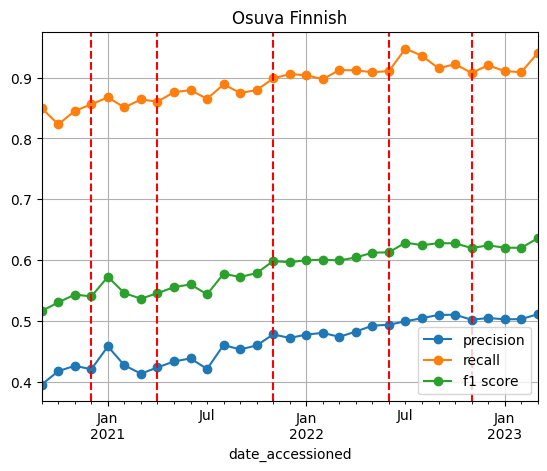

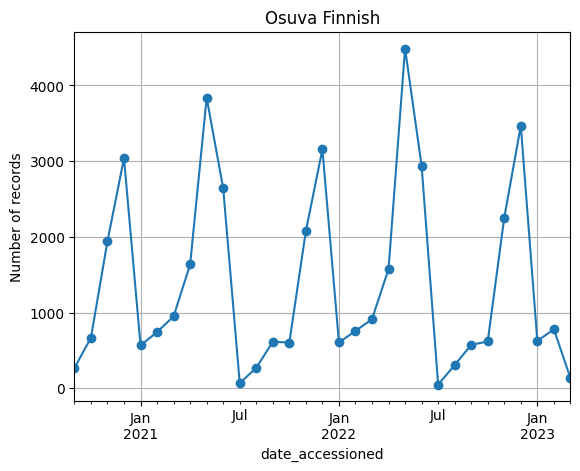

In [104]:
# date_isseued gives only the year, so we use date_accessioned
plot_scores(df_fi, "date_accessioned", groupby="M")
plt.title(title_str)

plt.figure()
# How many records there are each month?
df_fi.set_index('date_accessioned').resample("M").id.count().plot(marker='o')
plt.ylabel("Number of records")
plt.grid()
plt.title(title_str)

In [105]:
# Group by annif_update and give mean precision, recall, f1
df_fi.groupby("annif_update")['precision', 'recall', 'f1 score'].agg(['mean', 'count']).style.set_caption(title_str)

/tmp/ipykernel_818734/3516352905.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_fi.groupby("annif_update")['precision', 'recall', 'f1 score'].agg(['mean', 'count']).style.set_caption(title_str)


# Trepo
Annif integration to use in Trepo and Theseus in 7.9.2020

Note that the data set contains various document types, see below

In [106]:
with open("trepo.ndjson") as f:
    data = ndjson.load(f)
df = pd.DataFrame(data)

df.date_issued = pd.to_datetime(df.date_issued, errors='coerce', utc=True)
df.date_accessioned = pd.to_datetime(df.date_accessioned, errors='coerce', utc=True)
df['annif_update'] = df.date_accessioned.map(get_annif_update)

print(len(df))
print(len(df[df.language == 'fi']))
print(len(df[df.language == 'en']))
print(len(df[df.language == 'sv']))

68194
31729
26850
339


## Finnish

In [107]:
df_fi = df[df.language == 'fi']
df_fi = add_subjects_uris(df_fi, 'fi', source_col='subjects_all')
get_number_of_rows(df_fi)
# Retain only rows having both suggestions and subjects_uris
df_fi = retain_relevant(df_fi)
print()
df_fi.type.value_counts()
title_str = "Trepo Finnish"

missing fi label 'väsyminen' found via ysa
missing fi label 'arvot' found via ysa
missing fi label 'FEM' found via ysa
missing fi label 'itsesäätely' found via ysa
missing fi label 'arvot' found via ysa
missing fi label 'arvot' found via ysa
missing fi label 'arvo' found via ysa
missing fi label 'arvo' found via ysa
missing fi label 'arvo' found via ysa
missing fi label 'terveystieto' found via ysa
missing fi label 'arvot' found via ysa
missing fi label 'fantasia' found via ysa
missing fi label 'kuormat' found via ysa
missing fi label 'arvot' found via ysa
missing fi label 'sijoitukset' found via ysa
missing fi label 'arvo' found via ysa
missing fi label 'arvot' found via ysa
missing fi label 'sopimuksellisuus' found via ysa
missing fi label 'itsesäätely' found via ysa
missing fi label 'itsesäätely' found via ysa
missing fi label 'arvot' found via ysa
missing fi label 'arvot' found via ysa
missing fi label 'FEM' found via ysa
missing fi label 'arvot' found via ysa
missing fi label 'arv

/tmp/ipykernel_818734/2689655410.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["subjects_uris"] = df[source_col].apply(lambda x: [label_to_yso_uris(label, yso, lang, COMPLAIN) for label in x])
/tmp/ipykernel_818734/2689655410.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["subjects_uris"] = df["subjects_uris"].apply(lambda x: [str(item) for sublist in x for item in sublist])


rows:  31729
rows with subjects_yso:  4975
rows with subjects_all:  31086
rows with suggestions:  31729
rows with subjects_uris:  12321
rows with both suggestions & subject_uris:  5388



/tmp/ipykernel_818734/2689655410.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.resample(groupby).mean().plot(marker='o')


Text(0.5, 1.0, 'Trepo Finnish')

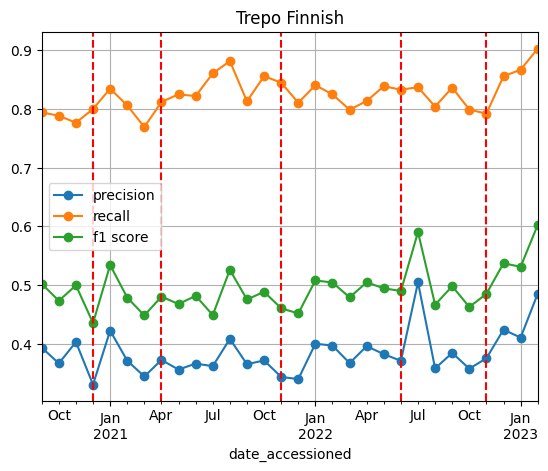

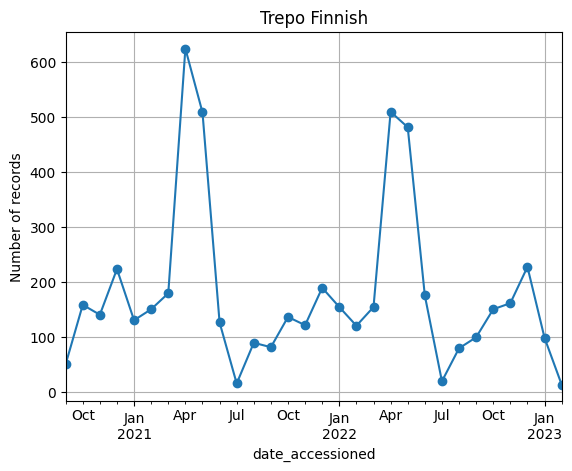

In [108]:
plot_scores(df_fi, "date_accessioned", groupby="M")
plt.title(title_str)

plt.figure()
# How many records there are with suggestions each month?
df_fi.set_index('date_accessioned').resample("M").id.count().plot(marker='o')
plt.ylabel("Number of records")
plt.grid()
plt.title(title_str)

In [109]:
# Group by annif_update and give mean precision, recall, f1
df_fi.groupby("annif_update")['precision', 'recall', 'f1 score'].agg(['mean', 'count']).style.set_caption(title_str)

/tmp/ipykernel_818734/3516352905.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_fi.groupby("annif_update")['precision', 'recall', 'f1 score'].agg(['mean', 'count']).style.set_caption(title_str)


Text(0.5, 0.98, 'Trepo Finnish')

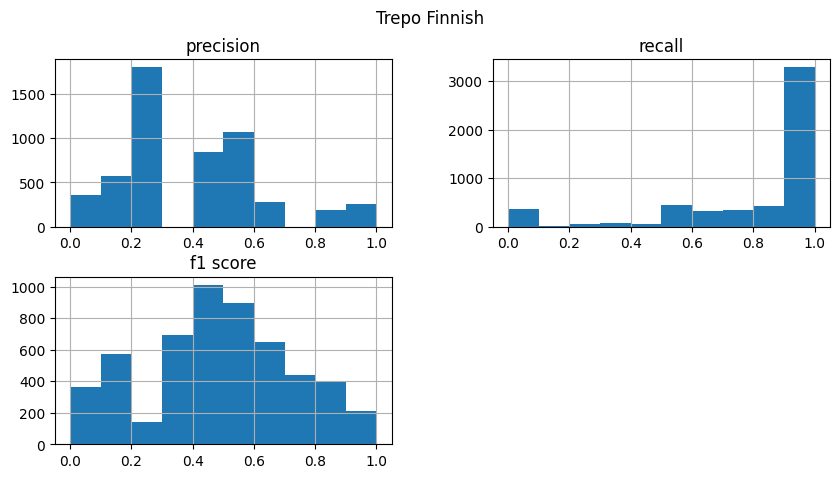

In [110]:
df_fi[['precision', 'recall', 'f1 score']].hist(bins=10, figsize=(10, 5))
plt.suptitle(title_str)

The histogram of recall above indicates that nearly never users assigns subjects that
are not suggested by Annif. 

## English

In [111]:
df_en = df[df.language == 'en']
df_en = add_subjects_uris(df_en, 'en', source_col='subjects_all')
get_number_of_rows(df_en)
# Retain only rows having both suggestions and subjects_uris
df_en = retain_relevant(df_en)
print()
df_en.type.value_counts()
title_str = "Trepo English"

Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
rows:  26850
rows with subjects_yso:  1334


/tmp/ipykernel_818734/2689655410.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["subjects_uris"] = df[source_col].apply(lambda x: [label_to_yso_uris(label, yso, lang, COMPLAIN) for label in x])
/tmp/ipykernel_818734/2689655410.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["subjects_uris"] = df["subjects_uris"].apply(lambda x: [str(item) for sublist in x for item in sublist])


rows with subjects_all:  25410
rows with suggestions:  26850
rows with subjects_uris:  4472
rows with both suggestions & subject_uris:  1415



/tmp/ipykernel_818734/2689655410.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.resample(groupby).mean().plot(marker='o')


Text(0.5, 1.0, 'Trepo English')

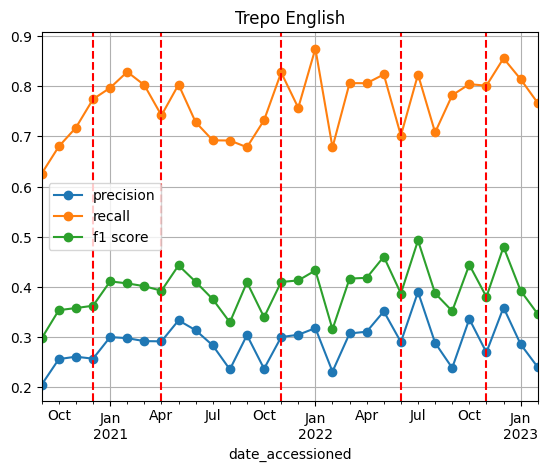

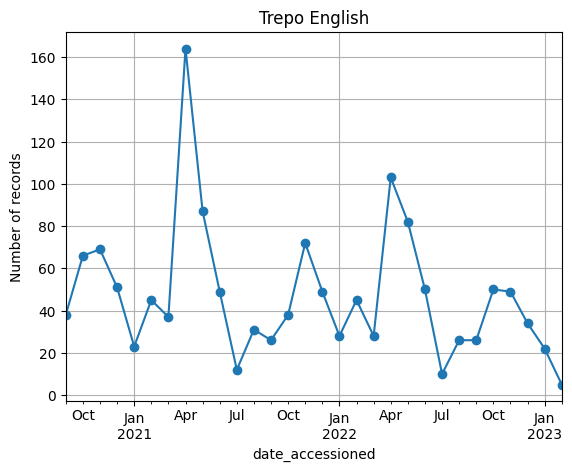

In [112]:
plot_scores(df_en, "date_accessioned", groupby="M")
plt.title(title_str)

plt.figure()
# How many records there are with suggestions each month?
df_en.set_index('date_accessioned')[df_en.set_index('date_accessioned').suggestions.apply(lambda x: len(x) > 0)].resample("M").count().date_issued.plot(marker='o')
plt.ylabel("Number of records")
plt.grid()
plt.title(title_str)

In [113]:
df_en.groupby("annif_update")['precision', 'recall', 'f1 score'].agg(['mean', 'count']).style.set_caption(title_str)

/tmp/ipykernel_818734/3185159461.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_en.groupby("annif_update")['precision', 'recall', 'f1 score'].agg(['mean', 'count']).style.set_caption(title_str)


Text(0.5, 0.98, 'Trepo English')

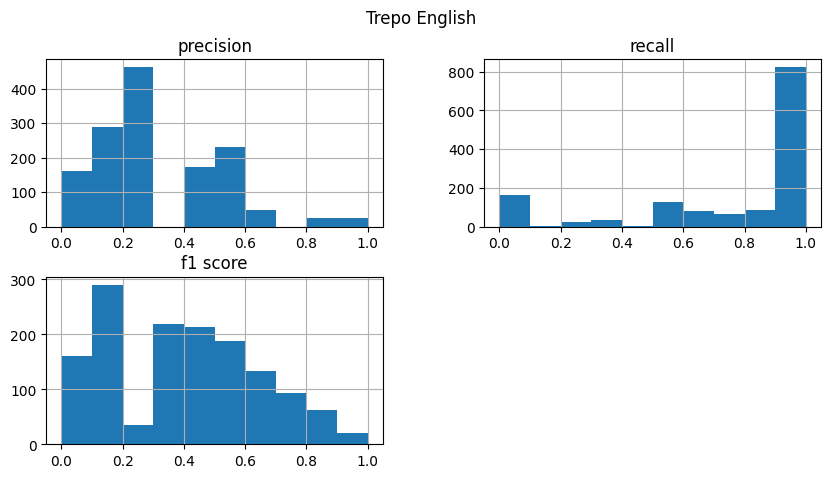

In [114]:
df_en[['precision', 'recall', 'f1 score']].hist(bins=10, figsize=(10, 5))
plt.suptitle(title_str)

# Theseus
Annif integration to use in Trepo and Theseus in 7.9.2020

Note that the data set contains various document types, see below

In [115]:
with open("theseus.ndjson") as f:
    data = ndjson.load(f)
df = pd.DataFrame(data)

df.date_issued = pd.to_datetime(df.date_issued, errors='coerce', utc=True)
df.date_accessioned = pd.to_datetime(df.date_accessioned, errors='coerce', utc=True)
df['annif_update'] = df.date_accessioned.map(get_annif_update)
df.rename(columns={'lang': 'language'}, inplace=True)


print(len(df))
df_fi = df[(df.language == 'fin') | (df.language == 'fi')]
print(len(df_fi))
df_en = df[(df.language == 'eng') | (df.language == 'en')]
print(len(df_en))
df_sv = df[(df.language == 'swe') | (df.language == 'sv')]
print(len(df_sv))

57488
47296
8102
1884


## Finnish

In [116]:
df_fi = add_subjects_uris(df_fi, 'fi', source_col='subjects_all')
get_number_of_rows(df_fi)
# Retain only rows having both suggestions and subjects_uris
df_fi = retain_relevant(df_fi)
print()
df_fi.type.value_counts()
title_str = "Theseus Finnish"

missing fi label 'itsesäätely' found via ysa
missing fi label 'arvot' found via ysa
missing fi label 'FEM' found via ysa
missing fi label 'vankeus' found via ysa
missing fi label 'lähteet' found via ysa
missing fi label 'asetukset' found via ysa
Error normalizing label 'None'
missing fi label 'arvot' found via ysa
missing fi label 'rajapinnat (tietokoneohjelmat)' found via ysa
missing fi label 'rajapinnat (tietokoneohjelmat)' found via ysa
missing fi label 'arvot' found via ysa
missing fi label 'esittely' found via ysa
missing fi label 'klubitalot' found via ysa
missing fi label 'arvot' found via ysa
missing fi label 'ekosysteemit' found via ysa
missing fi label 'biomassa' found via ysa
missing fi label 'maalit' found via ysa
missing fi label 'rajapinnat (tietokoneohjelmat)' found via ysa
missing fi label 'ekosysteemit' found via ysa
missing fi label 'ohjelmistot' found via ysa
missing fi label 'ohjelmistot' found via ysa
missing fi label 'arvot' found via ysa
missing fi label 'ohjelmi

/tmp/ipykernel_818734/2689655410.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["subjects_uris"] = df[source_col].apply(lambda x: [label_to_yso_uris(label, yso, lang, COMPLAIN) for label in x])
/tmp/ipykernel_818734/2689655410.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["subjects_uris"] = df["subjects_uris"].apply(lambda x: [str(item) for sublist in x for item in sublist])


rows:  47296
rows with subjects_yso:  45512
rows with subjects_all:  46718
rows with suggestions:  47296
rows with subjects_uris:  46498
rows with both suggestions & subject_uris:  43192



/tmp/ipykernel_818734/2689655410.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.resample(groupby).mean().plot(marker='o')


Text(0.5, 1.0, 'Theseus Finnish')

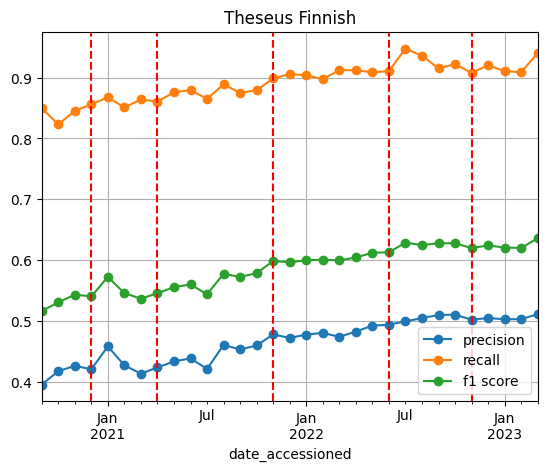

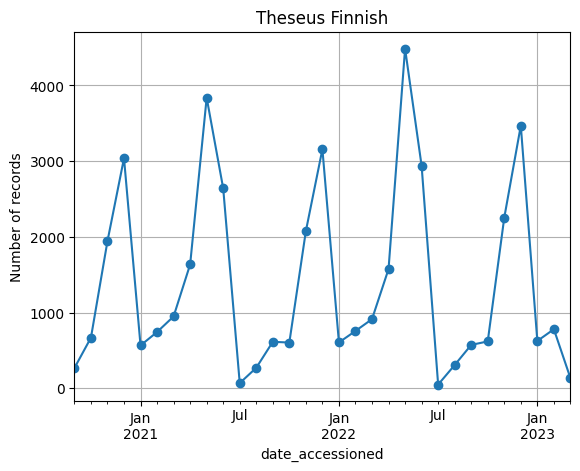

In [117]:
plot_scores(df_fi, "date_accessioned", groupby="M")
plt.title(title_str)
plt.figure()
# How many records there are with suggestions each month?
df_fi.set_index('date_accessioned').resample("M").id.count().plot(marker='o')
plt.ylabel("Number of records")
plt.grid()
plt.title(title_str)

In [118]:
# Group by annif_update and give mean precision, recall, f1
df_fi.groupby("annif_update")['precision', 'recall', 'f1 score'].agg(['mean', 'count']).style.set_caption(title_str)

/tmp/ipykernel_818734/3516352905.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_fi.groupby("annif_update")['precision', 'recall', 'f1 score'].agg(['mean', 'count']).style.set_caption(title_str)


Text(0.5, 0.98, 'Theseus Finnish')

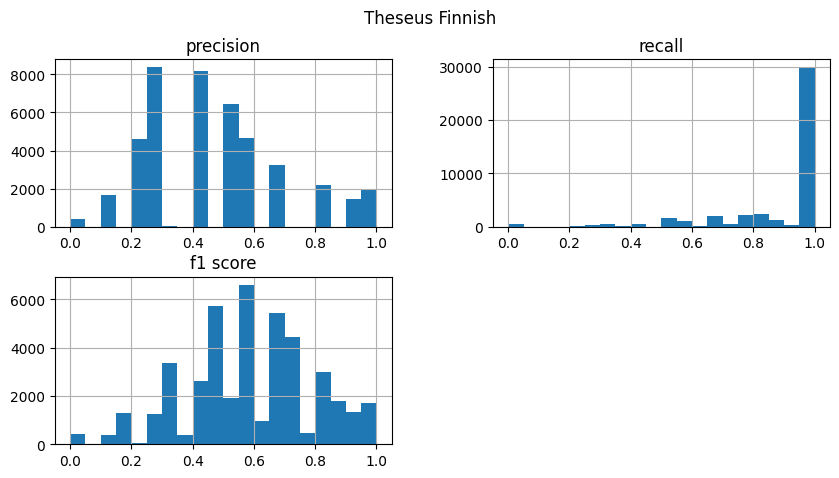

In [119]:
df_fi[['precision', 'recall', 'f1 score']].hist(bins=20, figsize=(10, 5))
plt.suptitle(title_str)

The histogram of recall above indicates that nearly never users assigns subjects that
are not suggested by Annif. 

## English

In [120]:
df_en = add_subjects_uris(df_en, 'en', source_col='subjects_all')
get_number_of_rows(df_en)
# Retain only rows having both suggestions and subjects_uris
df_en = retain_relevant(df_en)
print()
df_en.type.value_counts()
title_str = "Theseus English"

Error normalizing label 'None'
Error normalizing label 'None'
rows:  8102
rows with subjects_yso:  7464
rows with subjects_all:  7884
rows with suggestions:  8102
rows with subjects_uris:  7518
rows with both suggestions & subject_uris:  6703



/tmp/ipykernel_818734/2689655410.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["subjects_uris"] = df[source_col].apply(lambda x: [label_to_yso_uris(label, yso, lang, COMPLAIN) for label in x])
/tmp/ipykernel_818734/2689655410.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["subjects_uris"] = df["subjects_uris"].apply(lambda x: [str(item) for sublist in x for item in sublist])


/tmp/ipykernel_818734/2689655410.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.resample(groupby).mean().plot(marker='o')


Text(0.5, 1.0, 'Theseus English')

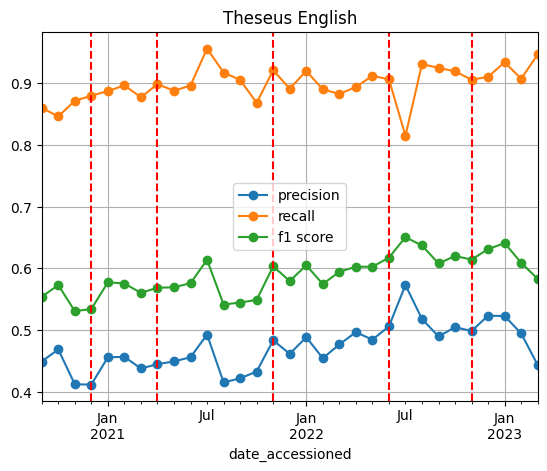

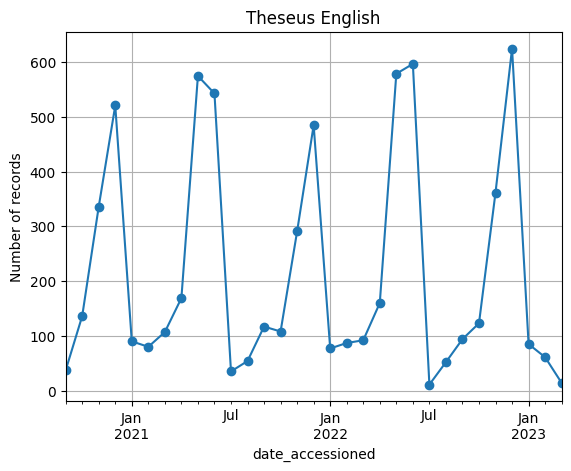

In [121]:
plot_scores(df_en, "date_accessioned", groupby="M")
plt.title(title_str)

plt.figure()
# How many records there are with suggestions each month?
df_en.set_index('date_accessioned')[df_en.set_index('date_accessioned').suggestions.apply(lambda x: len(x) > 0)].resample("M").count().date_issued.plot(marker='o')
plt.ylabel("Number of records")
plt.grid()
plt.title(title_str)

In [122]:
df_en.groupby("annif_update")['precision', 'recall', 'f1 score'].agg(['mean', 'count']).style.set_caption(title_str)

/tmp/ipykernel_818734/3185159461.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_en.groupby("annif_update")['precision', 'recall', 'f1 score'].agg(['mean', 'count']).style.set_caption(title_str)


Text(0.5, 0.98, 'Theseus English')

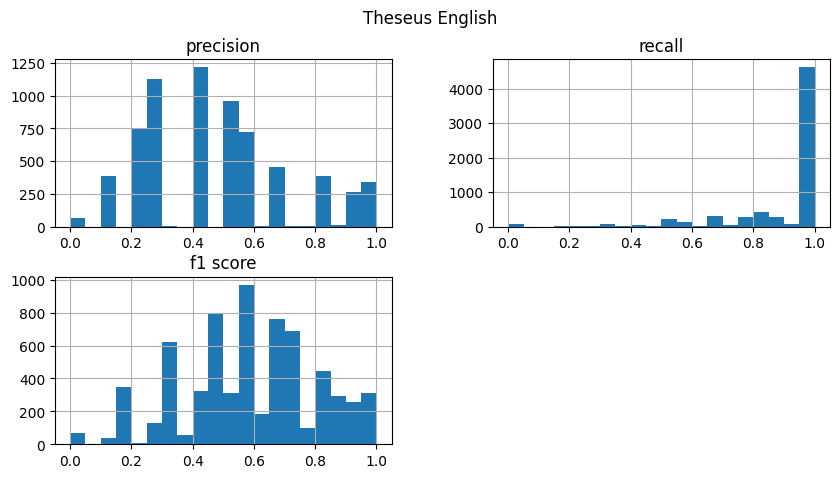

In [125]:
df_en[['precision', 'recall', 'f1 score']].hist(bins=20, figsize=(10, 5))
plt.suptitle(title_str)